In [3]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

import pandas as pd
import numpy as np
import gensim,re,time
from gensim.models.fasttext import load_facebook_model
from nltk.tokenize import RegexpTokenizer,TreebankWordTokenizer
from modules import utils
from sklearn.preprocessing import normalize
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, MeanShift, OPTICS
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.offline as py
import plotly.express as px
from gensim.test.utils import get_tmpfile
tokenizer = TreebankWordTokenizer()
from gensim.models import FastText

pca = PCA(n_components=3)
tsne = TSNE(n_components=3)

#Paramters
TOP_N_ARTICLES = 1000
TRAIN_N = 10000
%load_ext autoreload
%autoreload 2


### Load data and the model 

In [5]:
df = utils.load_text_data()
pdf=utils.preprocess_text(df.head(TOP_N_ARTICLES))
#tokenized_texts = [tokenizer.tokenize(txt) for txt in pdf ]


pdf[4]

'das hatte sich markus gisdol bei seiner vertragsverlängerung anfang august sicher auch alles ganz anders vorgestellt kölns cheftrainer geht mit zehn sieglosspielen aus der vergangenen rückrunde in die neue saison und neben diesem rucksack muss er jetzt auch noch in kürzester zeit verletzte spieler ersetzen und eine neue offensive installieren… der transfer von jhon cordoba nach berlin ist so gut wie perfekt nach bildinformationen soll dienstag alles klar sein gisdol steht schon vorm start unter druck der wahnsinn gisdol weiß nicht mal wen er gegen hoffenheim sa uhr auf den platz schicken kann ► topstar jhon cordoba treffer letzte saison haut nach berlin ab sein ersatz sebastian andersson kommt von union berlin muss wie herthas ondrej duda erst noch integriert werden grieche dimitrios limnios paok saolniki sitzt nach wie vor mit positivem coronatest in der heimat fest ► dazu kommen die vielen verletzten anthony modeste muss nach knieproblemen erst wieder anschluss finden florian kainz 

In [11]:
start_time = time.time()

#fb_model = load_facebook_model("cc.de.300.bin")
fb_model = load_facebook_model("../models/fasttext-bild100k.model")
print("--- Model loaded in %s seconds ---" % (time.time() - start_time))
fb_model.wv.most_similar(positive=['covid'])


NotImplementedError: Supervised fastText models are not supported

In [ ]:
print('covid' in fb_model.wv.vocab)  # Word is out of vocabulary
print('covidioten' in fb_model.wv.vocab)  # Word is out of vocabulary
print('coronavirus' in fb_model.wv.vocab)  # Word is out of vocabulary

In [ ]:
start_time = time.time()

fb_model.build_vocab(tokenized_texts, update=True)
fb_model.train(sentences=tokenized_texts, total_examples=len(tokenized_texts), epochs=15)
print("--- %s seconds ---" % (time.time() - start_time))


#fname = get_tmpfile("fasttext.model")
#fb_model.save(fname)

In [102]:
fb_model.wv.most_similar(positive=["virus","corona"])


[('corona-virus', 0.9479460716247559),
 ('coronavirus', 0.9341956377029419),
 ('corona-virus.', 0.9262381792068481),
 ('coronavirus.', 0.9100427627563477),
 ('coronavirus’', 0.9067225456237793),
 ('coronavirusncov', 0.9047183990478516),
 ('corona-viren', 0.8907731771469116),
 ('coronaviren', 0.8807787895202637),
 ('Coronavirus', 0.8795601725578308),
 ('coronavirus-epidemie', 0.8773820996284485)]

In [52]:
from collections import Counter
import itertools

def map_word_frequency(document):
    return Counter(itertools.chain(document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=fb_model):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    print(word_counts)
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set


def get_sif_feature_vec(sentence1, word_emb_model=fb_model):
    sentence1 = [token for token in tokenizer.tokenize(sentence1) if token in word_emb_model.wv.vocab and token not in utils.STOPWORDS]
    word_counts = map_word_frequency((sentence1))
    #print(word_counts)
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    vs = np.zeros(embedding_size)
    sentence_length = len(sentence1)
    for word in sentence1:
        a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
        vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
    vs = np.divide(vs, sentence_length) # weighted average
    return vs

In [55]:
#sentences_from_text = [ utils.get_sentences_from_text(txt) for txt in pdf]
#sentences_from_text[5]
#get_sif_feature_vec(pdf[0])

start_time = time.time()

vectors = []
for text in pdf:
    vectors.append(get_sif_feature_vec(text))
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-52-0531f6f887f3>:37: RuntimeWarning:

invalid value encountered in true_divide



--- 112.30100131034851 seconds ---


In [11]:
start_time = time.time()

#sentences_from_text = [ utils.get_sentences_from_text(txt) for txt in pdf]

#vectors = []
#for sentences in sentences_from_text:
#    ve=[]
#    for sen in sentences:
#        ve.append(np.array(fb_model[sen]))
#    vectors.append(np.mean(ve,axis=0))
#print("--- %s seconds ---" % (time.time() - start_time))
    

<ipython-input-11-3e8c68f9c425>:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:

Mean of empty slice.

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



--- 268.2316310405731 seconds ---


In [59]:
len(vectors[:500]),vectors[0].shape

(500, (300,))

In [14]:
pd.DataFrame(np.array(vectors)).to_csv("./tmps")

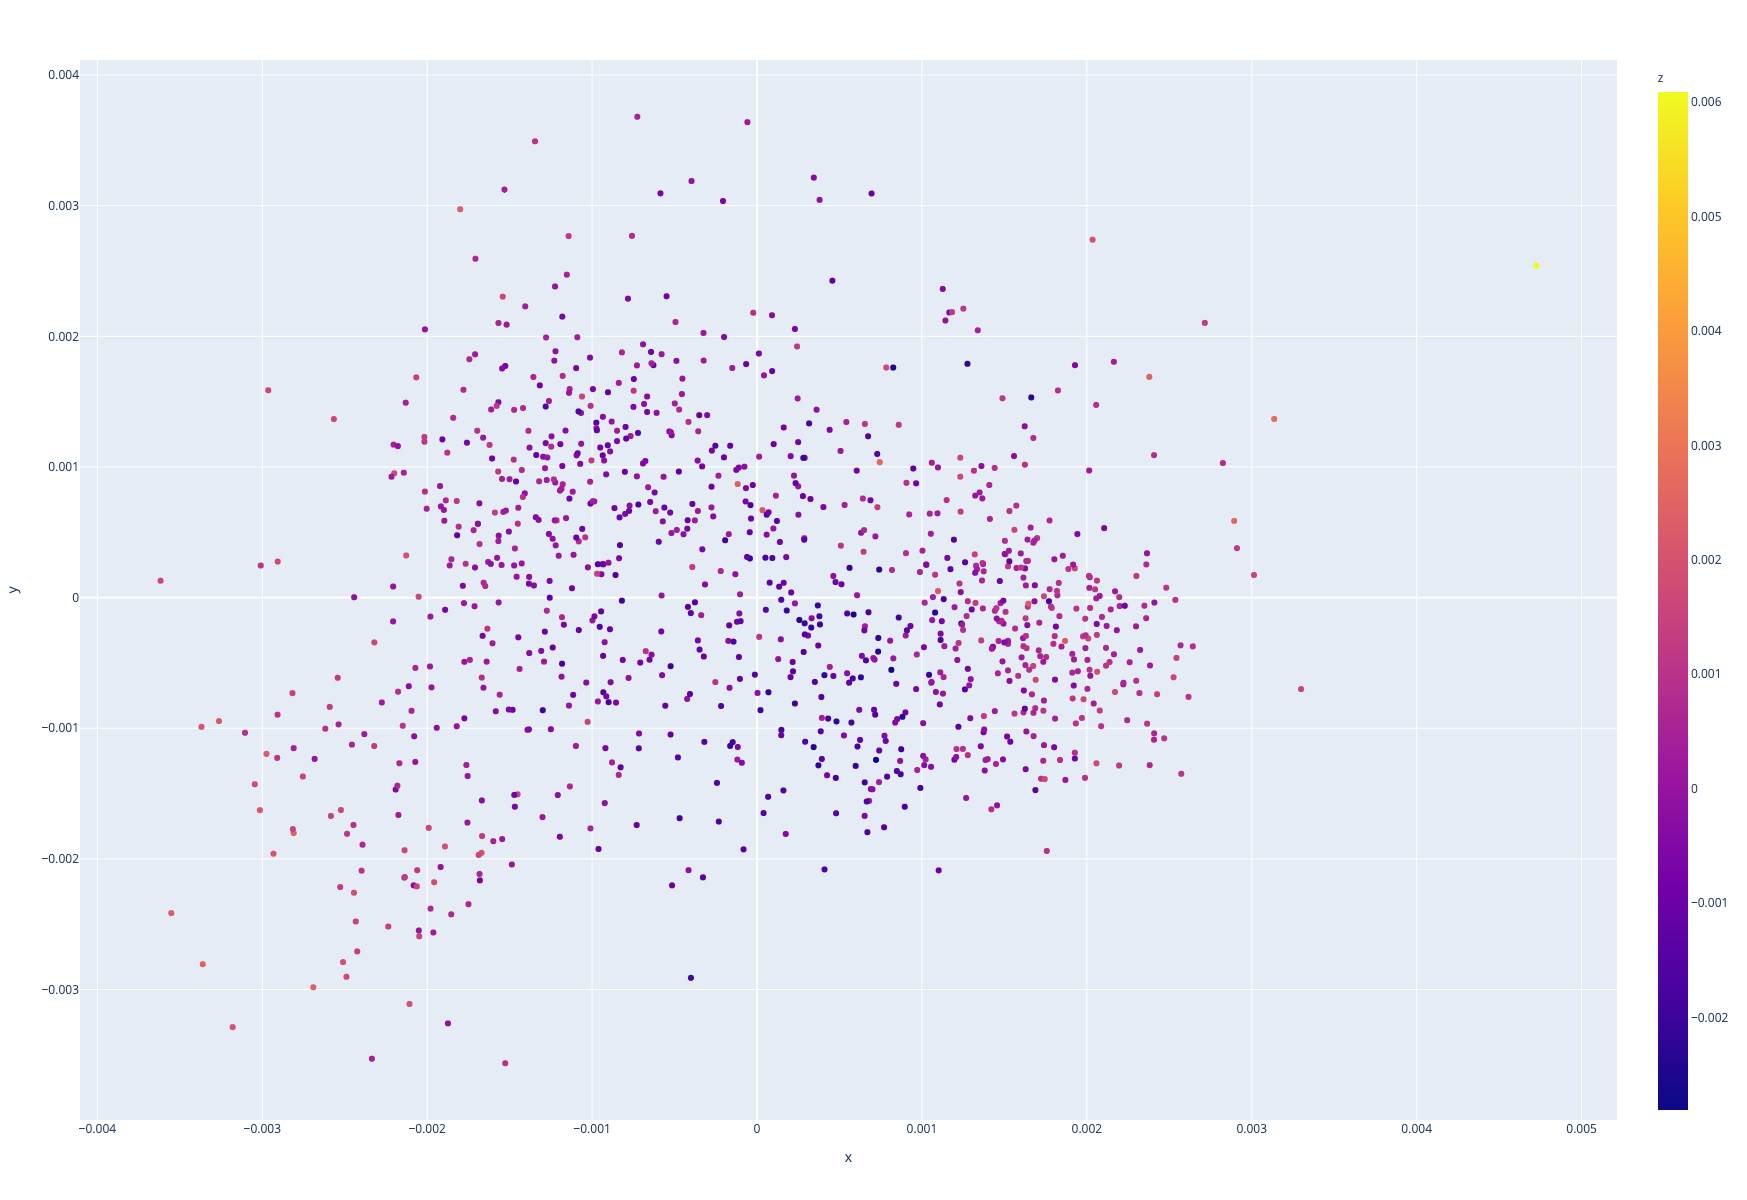

In [111]:
p = pca.fit_transform(np.array(vectors[:1000]))
p = pd.DataFrame(p,columns=["x",'y','z'])
p['headline'] = df.head(1000)["headline"].values
fig = px.scatter(p, x="x", y="y",hover_name="headline", color = "z", size_max=60)
fig.update_layout(
     height=1200)
fig.show()

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/hdbscan/hdbscan_.py:217: UserWarning:

Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 



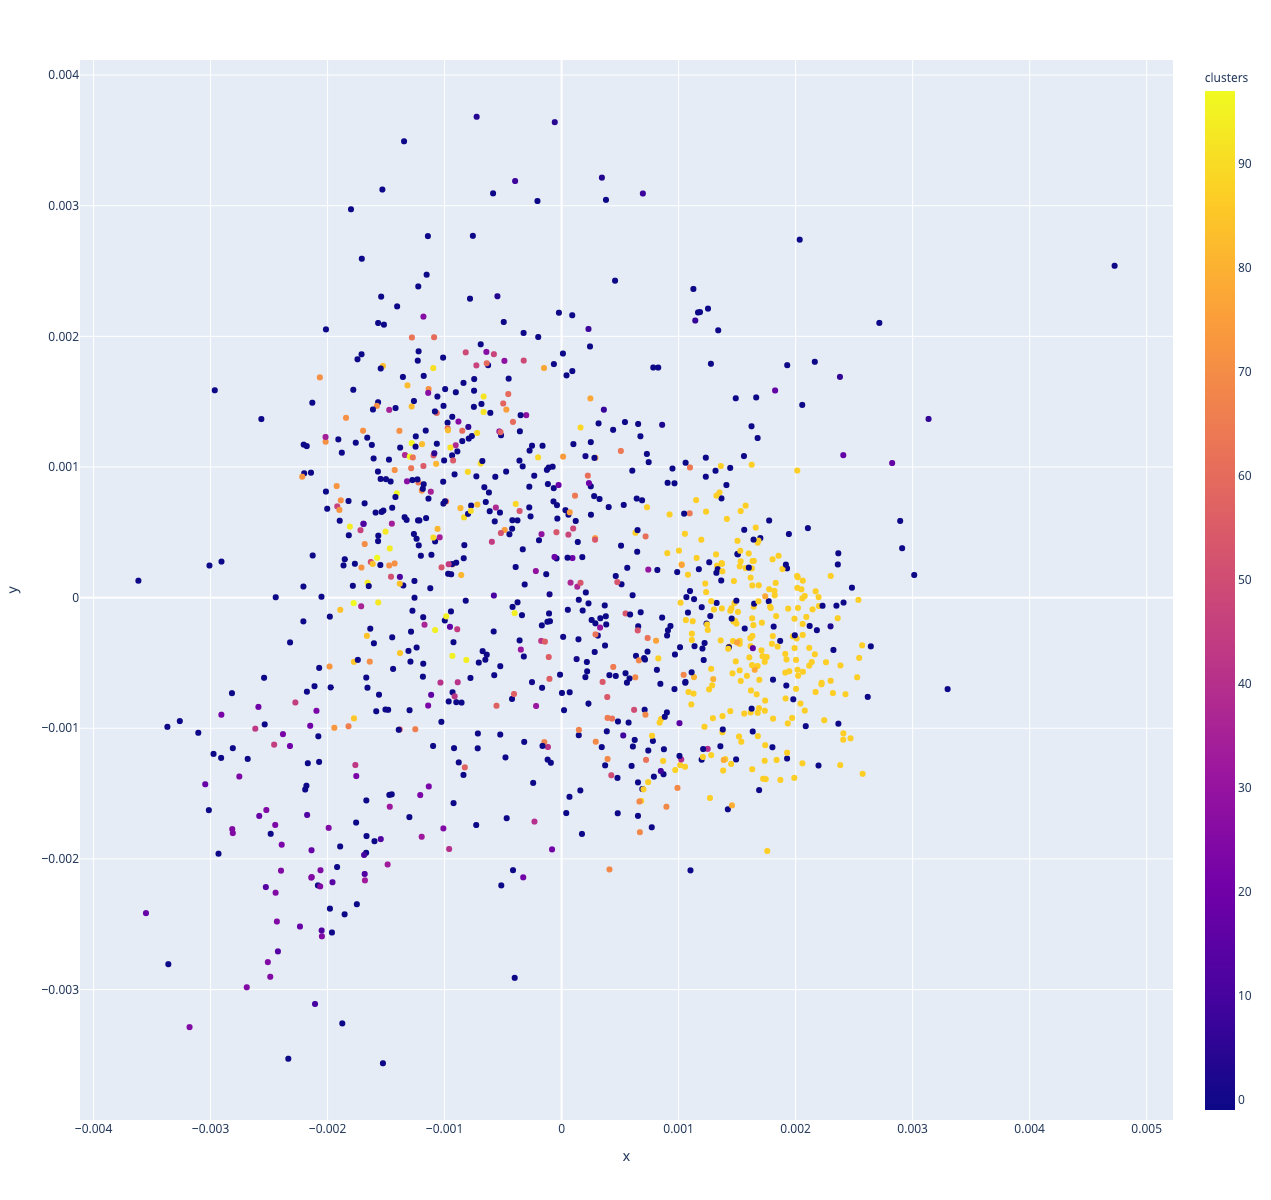

In [115]:
clusterer = HDBSCAN(algorithm='best', alpha=0.5, approx_min_span_tree=False,
    gen_min_span_tree=True, leaf_size=20,
metric='euclidean', min_cluster_size=2, min_samples=2, p=None)

#clusterer = DBSCAN(metric=cosine_distances)

cluster_labels = clusterer.fit_predict(normalize(vectors[:1000],norm="l2"))
p["clusters"] = cluster_labels
fig = px.scatter(p, x="x", y="y",hover_name="headline", color = "clusters", size_max=60)
fig.update_layout(
     height=1200)

In [1]:
#!/usr/bin/env python3

# Copyright (c) 2017-2018 Symantec Corporation. All Rights Reserved. 
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#
# 1. Redistributions of source code must retain the above copyright
# notice, this list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright
# notice, this list of conditions and the following disclaimer in the
# documentation and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its
# contributors may be used to endorse or promote products derived from
# this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS
# FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE
# COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT,
# INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING,
# BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
# LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN
# ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

import argparse
import collections
import itertools

import numpy as np
import numpy.linalg
import sklearn.datasets
import matplotlib.pyplot as plt

from flexible_clustering import FISHDBC
    
parser = argparse.ArgumentParser(description="""
Show an example of running FISHDBC.
This will plot points that are naturally clustered and added incrementally,
and then loop through all the hierarchical clusters recognized by the
algorithm.

Original clusters are shown in different colors while each cluster found by
FISHDBC is shown in red; press a key or click the mouse button to loop through
clusters.""")
parser.add_argument('--nitems', type=int, default=200,
                    help="Number of items (default 200).")
parser.add_argument('--niters', type=int, default=4,
                    help="Clusters are shown in NITERS stage while being "
                    "added incrementally (default 4).")
parser.add_argument('--centers', type=int, default=5,
                    help="Number of centers for the clusters generated "
                    "(default 5).")
args = parser.parse_args()

data, labels = sklearn.datasets.make_blobs(args.nitems,
                                           centers=args.centers)
x, y = data[:, 0], data[:, 1]

def distance(x, y):
    return numpy.linalg.norm(x - y)
    
fishdbc = FISHDBC(distance)

plt.figure(figsize=(9, 9))
plt.gca().set_aspect('equal')

for points in np.split(data, args.niters):
    fishdbc.update(points)
    nknown = len(fishdbc.data)
    _, _, _, ctree, _, _ = fishdbc.cluster()
    clusters = collections.defaultdict(set)
    for parent, child, lambda_val, child_size in ctree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = x[:nknown], y[:nknown], labels[:nknown]
    color = ['rgbcmyk'[l % 7] for l in labels_known]
    plt.scatter(xknown, yknown, c=color, linewidth=0)
    plt.show(block=False)
    for _, cluster in clusters:
        plt.waitforbuttonpress()
        plt.gca().clear()
        color = ['kr'[i in cluster] for i in range(nknown)]
        plt.scatter(xknown, yknown, c=color, linewidth=0)
        plt.draw()


usage: ipykernel_launcher.py [-h] [--nitems NITEMS] [--niters NITERS]
                             [--centers CENTERS]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/tomasztkaczyk/Library/Jupyter/runtime/kernel-745058f9-e7bd-4d6c-ae10-0ed37f8fe5ba.json


SystemExit: 2

/Users/tomasztkaczyk/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
